In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import cross_val_score

In [12]:
# Read Excel file and save as DataFrame

df = pd.read_excel('./Datasets/tobacco_data.xlsx')
df.columns = df.iloc[0]
df = df[1:]
df.head()

,Intervention_descriptor,tax_increase,outlet_reduction,dec_smoking_prevalence,dec_tobacco_supply,dec_smoking_uptake,age,gender,ethnicity,discount_rate,evidence_strength,qalys_pc,hs_costs_pc
1,Combined tobacco endgame strategy (tobacco-fre...,10,90,7,0,0,0-14,Male,non-Māori,0,NaN,40.865526,-1284765.096725
2,Combined tobacco endgame strategy (tobacco-fre...,10,90,7,0,0,15-24,Male,non-Māori,0,NaN,41.708939,-1270055.987675
3,Combined tobacco endgame strategy (tobacco-fre...,10,90,7,0,0,25-44,Male,non-Māori,0,NaN,13.282615,-318700.524314
4,Combined tobacco endgame strategy (tobacco-fre...,10,90,1,0,0,45-64,Male,non-Māori,0,NaN,7.222291,-119003.652181
5,Combined tobacco endgame strategy (tobacco-fre...,10,90,0.5,0,0,65+,Male,non-Māori,0,NaN,1.111505,-9656.694651


In [13]:
# Transform data

# Map age group to integer
avg_age_mapping = {
    '0-14': 7,
    '15-24': 20,
    '25-44': 33,
    '45-64': 55,
    '65+': 75
}

# Map gender to integer
gender_mapping = {
    'Male': 0,
    'Female': 1
}

# Map ethnicity to integer
ethnicity_mapping = {
    'Māori': 0,
    'non-Māori': 1
}

# Apply the mapping to the 'Age_Group' column
df['average_age'] = df['age'].map(avg_age_mapping)
df['gender_idx'] = df['gender'].map(gender_mapping)
df['ethnicity_idx'] = df['ethnicity'].map(ethnicity_mapping)

# Impute missing values in 'average_age' with the mean
df['average_age'] = df['average_age'].fillna(df['average_age'].mean())

# Impute missing values in 'gender_idx' and 'ethnicity_idx' with the mode
df['gender_idx'] = df['gender_idx'].fillna(df['gender_idx'].mode()[0])
df['ethnicity_idx'] = df['ethnicity_idx'].fillna(df['ethnicity_idx'].mode()[0])

# Convert the specified columns to floats
df[['tax_increase', 'outlet_reduction', 'dec_smoking_prevalence', 
    'dec_tobacco_supply', 'dec_smoking_uptake', 'qalys_pc']] = df[['tax_increase', 'outlet_reduction', 
    'dec_smoking_prevalence', 'dec_tobacco_supply', 'dec_smoking_uptake', 'qalys_pc']].apply(pd.to_numeric, errors='coerce').astype('float')

# Columns to be used for model building
df_vape = df[['tax_increase', 'outlet_reduction', 'dec_smoking_prevalence', 
              'dec_tobacco_supply', 'dec_smoking_uptake', 'average_age', 
              'gender_idx', 'ethnicity_idx', 'qalys_pc']]

# Display updated DataFrame
df_vape.head()

,tax_increase,outlet_reduction,dec_smoking_prevalence,dec_tobacco_supply,dec_smoking_uptake,average_age,gender_idx,ethnicity_idx,qalys_pc
1,10.0,90.0,7.0,0.0,0.0,7.0,0.0,1.0,40.865526
2,10.0,90.0,7.0,0.0,0.0,20.0,0.0,1.0,41.708939
3,10.0,90.0,7.0,0.0,0.0,33.0,0.0,1.0,13.282615
4,10.0,90.0,1.0,0.0,0.0,55.0,0.0,1.0,7.222291
5,10.0,90.0,0.5,0.0,0.0,75.0,0.0,1.0,1.111505


In [14]:
df_vape

,tax_increase,outlet_reduction,dec_smoking_prevalence,dec_tobacco_supply,dec_smoking_uptake,average_age,gender_idx,ethnicity_idx,qalys_pc
1,10.0,90.0,7.0,0.0,0.0,7.0,0.0,1.0,40.865526
2,10.0,90.0,7.0,0.0,0.0,20.0,0.0,1.0,41.708939
3,10.0,90.0,7.0,0.0,0.0,33.0,0.0,1.0,13.282615
4,10.0,90.0,1.0,0.0,0.0,55.0,0.0,1.0,7.222291
5,10.0,90.0,0.5,0.0,0.0,75.0,0.0,1.0,1.111505
...,...,...,...,...,...,...,...,...,...
103,0.0,0.0,7.0,0.0,0.0,20.0,1.0,1.0,28.135048
104,0.0,0.0,16.0,0.0,0.0,7.0,0.0,0.0,100.762066
105,0.0,0.0,16.0,0.0,0.0,20.0,0.0,0.0,88.425926
106,0.0,0.0,16.0,0.0,0.0,7.0,1.0,0.0,147.424512


In [15]:
def display_pca(df):
    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df)
    
    # Apply PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    
    # Check variance ratio for the first two components
    explained_variance = pca.explained_variance_ratio_
    print(f"Explained variance by component 1: {explained_variance[0]:.2f}")
    print(f"Explained variance by component 2: {explained_variance[1]:.2f}")
    
    # Create a scatter plot of the PCA results
    plt.figure(figsize=(8, 6))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c='blue', edgecolor='k', s=50)
    
    # Add labels and title
    plt.xlabel(f"Principal Component 1 ({explained_variance[0]:.2f} variance)")
    plt.ylabel(f"Principal Component 2 ({explained_variance[1]:.2f} variance)")
    plt.title("PCA of Dataset")
    plt.grid(True)
    
    # Show plot
    plt.show()

In [16]:
def simple_duplicate(X, y, n_samples=200, std_dev=0.4, random_state=None):
    """
    Duplicate X and y with added Gaussian noise.
    
    Parameters:
        X (numpy.ndarray): Feature matrix.
        y (numpy.ndarray): Target values.
        n_samples (int): Number of new samples to generate.
        std_dev (float): Standard deviation of the noise.
        random_state (int, optional): Seed for reproducibility.

    Returns:
        X_aug (numpy.ndarray): Augmented feature matrix.
        y_aug (numpy.ndarray): Augmented target values.
    """
    if random_state is not None:
        np.random.seed(random_state)
    
    # Select random samples from X and y
    indices = np.random.choice(X.shape[0], size=n_samples, replace=True)
    X_selected = X[indices]
    y_selected = y[indices]
    
    # Add Gaussian noise to X
    noise = np.random.normal(loc=0.0, scale=std_dev, size=X_selected.shape)
    X_aug = X_selected + noise
    
    # Keep y unchanged or add noise to y if needed (optional)
    y_aug = y_selected  # Add noise to y if required: y_selected + np.random.normal(0, std_dev, size=y_selected.shape)
    
    return X_aug, y_aug

Generating Synthetic Samples
Explained variance by component 1: 0.34
Explained variance by component 2: 0.19


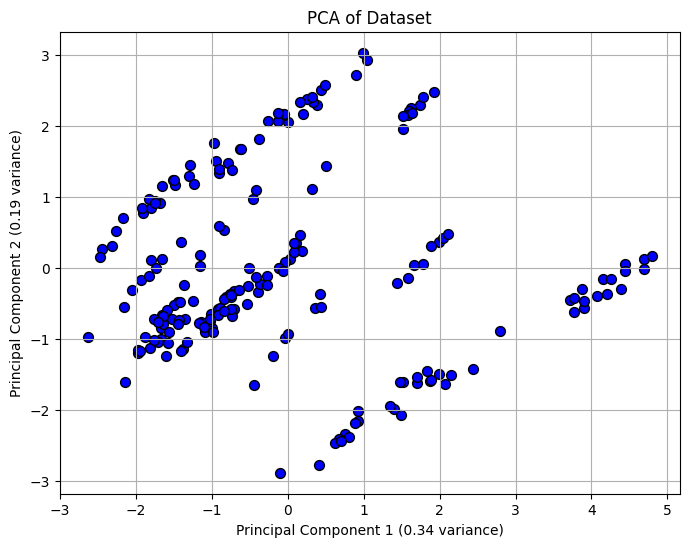

In [17]:
columns = ['tax_increase', 'outlet_reduction', 'dec_smoking_prevalence', 
              'dec_tobacco_supply', 'dec_smoking_uptake', 'average_age', 
              'gender_idx', 'ethnicity_idx']
X = df_vape[columns]
y = df_vape[['qalys_pc']]
    
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
y_flat = y_train.values.flatten() # Ensure that y is a 1D array for compatibility
    
# Generate synthetic samples
print("Generating Synthetic Samples")
X_sim, y_sim = simple_duplicate(X_train.values, y_flat, n_samples=200, random_state=42)

columns = ['tax_increase', 'outlet_reduction', 'dec_smoking_prevalence', 
              'dec_tobacco_supply', 'dec_smoking_uptake', 'average_age', 
              'gender_idx', 'ethnicity_idx']
df_duplicated = pd.DataFrame(X_sim, columns=columns)
df_duplicated['qalys_pc'] = y_sim

display_pca(df_duplicated)

In [31]:
from sklearn.linear_model import LinearRegression

# Initialize the Linear Regression model
model = LinearRegression()

X_sim = pd.DataFrame(X_sim, columns=columns)
# Fit the model to the training data
model.fit(X_sim, y_sim)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
lr_mape = mape(y_test, y_pred)
lr_mape

np.float64(11.32514486020487)

In [32]:
summary = pd.DataFrame([[1,2,3,4],
                       [1,2,3,4],
                       [1,2,3,4],
                       [1,2,3,4]],
                        index = ['LinearRegression', 'RF No Bootstrap', 'RF Bootstrap', 'XGBoost'],
                        columns = ['No Upsampling', 'Simple Duplication', 'KNN', 'Rebalanced KNN'])
summary

,No Upsampling,Simple Duplication,KNN,Rebalanced KNN
LinearRegression,1,2,3,4
RF No Bootstrap,1,2,3,4
RF Bootstrap,1,2,3,4
XGBoost,1,2,3,4


In [33]:
def simple_duplicate(X, y, n_samples=200, random_state=42, noise_std=0.1):
    # Set random state for reproducibility
    if random_state is not None:
        np.random.seed(random_state)

    # Determine how many times to duplicate the dataset
    n_repeats = n_samples // len(X)

    # Duplicate the data n_repeats times
    X_res = np.tile(X, (n_repeats, 1))
    y_res = np.tile(y, n_repeats)

    # Add Gaussian noise to the duplicated data
    noise = np.random.normal(0, 0.1, size=X_res.shape)
    X_res = X_res + noise

    return X_res, y_res

In [34]:
# Function to generate synthetic samples
def generate_synthetic_samples(X, y, n_samples, random_state=42):
    np.random.seed(random_state)
    nn = NearestNeighbors(n_neighbors=5)
    nn.fit(X)

    synthetic_X = []
    synthetic_y = []
    for _ in range(n_samples):
        idx = np.random.randint(0, len(X))
        neighbors = nn.kneighbors([X[idx]], return_distance=False)[0]
        
        neighbor_idx = np.random.choice(neighbors)
        lam = np.random.uniform(0, 1)
        
        # Generate synthetic sample using interpolation
        new_sample_X = X[idx] + lam * (X[neighbor_idx] - X[idx])
        new_sample_y = y[idx] + lam * (y[neighbor_idx] - y[idx])
        
        synthetic_X.append(new_sample_X)
        synthetic_y.append(new_sample_y)
    
    return np.array(synthetic_X), np.array(synthetic_y)

In [7]:
def generate_synthetic_samples_imbalanced(X, y, n_samples, threshold=0.2, random_state=42):
    np.random.seed(random_state)
    nn = NearestNeighbors(n_neighbors=5)
    nn.fit(X)

    # Calculate distances to the nearest neighbors
    distances, _ = nn.kneighbors(X)

    # Calculate the number of neighbors within the threshold for each sample
    neighbors_within_threshold = np.sum(distances[:, 1:] < threshold, axis=1)

    # Calculate inverse probabilities
    selection_probabilities = 1 / (neighbors_within_threshold + 1e-6)  # Add small constant to avoid division by zero
    selection_probabilities /= selection_probabilities.sum()  # Normalize to sum to 1

    synthetic_X = []
    synthetic_y = []

    for _ in range(n_samples):
        # Select a sample based on the weighted probability distribution
        idx = np.random.choice(len(X), p=selection_probabilities)

        # Select a random neighbor of the chosen sample
        neighbors = nn.kneighbors([X[idx]], return_distance=False)[0]
        neighbor_idx = np.random.choice(neighbors)

        # Linear interpolation for synthetic sample generation
        lam = np.random.uniform(0, 1)
        new_sample_X = X[idx] + lam * (X[neighbor_idx] - X[idx])
        new_sample_y = y[idx] + lam * (y[neighbor_idx] - y[idx])

        synthetic_X.append(new_sample_X)
        synthetic_y.append(new_sample_y)

    return np.array(synthetic_X), np.array(synthetic_y)

In [8]:
def rf_bootstrap(X_train, X_test, y_train, y_test):

    # Define the RandomForestRegressor model
    rf_model = RandomForestRegressor(random_state=42, bootstrap=True)
    
    # Define the parameter grid to search over
    param_grid = {
        'n_estimators': [100, 200, 300],    # Number of trees in the forest
        'max_depth': [5, 10, 20],            # Maximum depth of the tree
        'min_samples_leaf': [1, 5, 10],      # Minimum number of samples required to be at a leaf node
        'max_samples': [0.5, 0.7, 1.0],     # Maximum number of samples to draw from the data with replacement
    }
    
    # Define the MAPE scorer (using Mean Absolute Percentage Error)
    mape_scorer = make_scorer(mape, greater_is_better=False)
    
    # Setup GridSearchCV to perform cross-validation
    grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid, 
                                  scoring=mape_scorer, cv=5, verbose=1, n_jobs=-1)
    
    # Fit the grid search to the duplicated training data
    grid_search_rf.fit(X_train, y_train)
    
    # Best hyperparameters from grid search
    print("Best Parameters for Random Forest:", grid_search_rf.best_params_)
    
    # Best MAPE score from cross-validation
    print("Best MAPE for Random Forest:", -grid_search_rf.best_score_)
    
    # Train a final model using the best parameters
    best_rf_model = grid_search_rf.best_estimator_
    
    # Evaluate on the test set
    y_pred_rf = best_rf_model.predict(X_test)
    
    # Calculate the test MAPE
    test_mape_rf = mape(y_test, y_pred_rf)
    print("Test MAPE for Random Forest:", test_mape_rf)

    return best_rf_model, test_mape_rf

In [9]:
def rf_bootstrap_cv(X_train, X_test, y_train, y_test, cv=5):    
    # Define the RandomForestRegressor model
    rf_model = RandomForestRegressor(random_state=42, bootstrap=True)
    
    # Define the parameter grid to search over
    param_grid = {
        'n_estimators': [100, 200, 300],    # Number of trees in the forest
        'max_depth': [5, 10, 20],           # Maximum depth of the tree
        'min_samples_leaf': [1, 5, 10],     # Minimum samples required at a leaf node
        'max_samples': [0.5, 0.7, 1.0],     # Maximum samples to draw from the data
    }
    
    # Define the MAPE scorer (using Mean Absolute Percentage Error)
    mape_scorer = make_scorer(mape, greater_is_better=False)
    
    # Convert y_train to a 1D array using NumPy's ravel()
    y_train_1d = np.ravel(y_train)

    # Setup GridSearchCV to perform cross-validation
    grid_search_rf = GridSearchCV(
        estimator=rf_model, 
        param_grid=param_grid, 
        scoring=mape_scorer, 
        cv=cv, 
        verbose=1, 
        n_jobs=-1
    )
    
    # Fit the grid search to the training data
    grid_search_rf.fit(X_train, y_train_1d)
    
    # Get the best hyperparameters and best score from grid search
    best_rf_model = grid_search_rf.best_estimator_
    best_params_rf = grid_search_rf.best_params_
    best_mape_rf = -grid_search_rf.best_score_
    
    print("Best Parameters for Random Forest:", best_params_rf)
    print("Best CV MAPE for Random Forest:", best_mape_rf)
    
    # Perform cross-validation with the best model to get average MAPE
    cv_mape_scores = cross_val_score(
        best_rf_model, 
        X_train, 
        y_train_1d, 
        scoring=mape_scorer, 
        cv=cv, 
        n_jobs=-1
    )
    avg_cv_mape = -cv_mape_scores.mean()
    
    print(f"Average CV MAPE for Random Forest: {avg_cv_mape}")
    
    # Train the final model using the best parameters
    best_rf_model.fit(X_train, y_train_1d)
    
    # Evaluate on the test set
    y_pred_rf = best_rf_model.predict(X_test)
    test_mape_rf = mape(y_test, y_pred_rf)
    print("Test MAPE for Random Forest:", test_mape_rf)

    return best_rf_model, avg_cv_mape, test_mape_rf

In [10]:
def rf_no_bootstrap(X_train, X_test, y_train, y_test):    
    # Define the RandomForestRegressor model with bootstrap disabled
    rf_model_no_bootstrap = RandomForestRegressor(random_state=42, bootstrap=False)
    
    # Define the parameter grid to search over
    param_grid_no_bootstrap = {
        'n_estimators': [100, 200, 300],    # Number of trees in the forest
        'max_depth': [3, 5, 10],            # Maximum depth of the tree
        'min_samples_leaf': [1, 2, 4],      # Minimum number of samples required to be at a leaf node
    }
    
    # Define the MAPE scorer (using Mean Absolute Percentage Error)
    mape_scorer = make_scorer(mape, greater_is_better=False)
    
    # Setup GridSearchCV to perform cross-validation
    grid_search_rf_no_bootstrap = GridSearchCV(estimator=rf_model_no_bootstrap, param_grid=param_grid_no_bootstrap, 
                                               scoring=mape_scorer, cv=5, verbose=1, n_jobs=-1)
    
    # Fit the grid search to the duplicated training data
    grid_search_rf_no_bootstrap.fit(X_train, y_train)
    
    # Best hyperparameters from grid search
    print("Best Parameters for Random Forest (No Bootstrap):", grid_search_rf_no_bootstrap.best_params_)
    
    # Best MAPE score from cross-validation
    print("Best MAPE for Random Forest (No Bootstrap):", -grid_search_rf_no_bootstrap.best_score_)
    
    # Train a final model using the best parameters
    best_rf_model_no_bootstrap = grid_search_rf_no_bootstrap.best_estimator_
    
    # Evaluate on the test set
    y_pred_rf_no_bootstrap = best_rf_model_no_bootstrap.predict(X_test)
    
    # Calculate the test MAPE
    test_mape_rf_no_bootstrap = mape(y_test, y_pred_rf_no_bootstrap)
    print("Test MAPE for Random Forest (No Bootstrap):", test_mape_rf_no_bootstrap)

    return best_rf_model_no_bootstrap, test_mape_rf_no_bootstrap

In [11]:
def rf_no_bootstrap_cv(X_train, X_test, y_train, y_test, cv=5):
    """
    Trains a RandomForestRegressor model without bootstrap, using cross-validation
    and GridSearchCV to find the best hyperparameters. Returns the best model,
    average CV MAPE, and test MAPE.
    
    Parameters:
    - X_train: Training features
    - X_test: Test features
    - y_train: Training target
    - y_test: Test target
    - cv: Number of cross-validation folds (default: 5)

    Returns:
    - best_rf_model_no_bootstrap: Trained RandomForestRegressor model with best parameters
    - avg_cv_mape_no_bootstrap: Average MAPE from cross-validation
    - test_mape_rf_no_bootstrap: MAPE on the test set
    """
    
    # Define the RandomForestRegressor model with bootstrap disabled
    rf_model_no_bootstrap = RandomForestRegressor(random_state=42, bootstrap=False)

    # Define the parameter grid to search over
    param_grid_no_bootstrap = {
        'n_estimators': [100, 200, 300],    # Number of trees in the forest
        'max_depth': [3, 5, 10],            # Maximum depth of the tree
        'min_samples_leaf': [1, 2, 4],      # Minimum samples required at a leaf node
    }

    # Define the MAPE scorer (using Mean Absolute Percentage Error)
    mape_scorer = make_scorer(mape, greater_is_better=False)

    # Convert y_train to a 1D array using NumPy's ravel()
    y_train_1d = np.ravel(y_train)

    # Setup GridSearchCV to perform cross-validation
    grid_search_rf_no_bootstrap = GridSearchCV(
        estimator=rf_model_no_bootstrap, 
        param_grid=param_grid_no_bootstrap, 
        scoring=mape_scorer, 
        cv=cv, 
        verbose=1, 
        n_jobs=-1
    )

    # Fit the grid search to the training data
    grid_search_rf_no_bootstrap.fit(X_train, y_train_1d)

    # Get the best hyperparameters and best score from grid search
    best_rf_model_no_bootstrap = grid_search_rf_no_bootstrap.best_estimator_
    best_params_rf_no_bootstrap = grid_search_rf_no_bootstrap.best_params_
    best_cv_mape_no_bootstrap = -grid_search_rf_no_bootstrap.best_score_

    print("Best Parameters for Random Forest (No Bootstrap):", best_params_rf_no_bootstrap)
    print("Best CV MAPE for Random Forest (No Bootstrap):", best_cv_mape_no_bootstrap)

    # Perform cross-validation with the best model to get average MAPE
    cv_mape_scores_no_bootstrap = cross_val_score(
        best_rf_model_no_bootstrap, 
        X_train, 
        y_train_1d, 
        scoring=mape_scorer, 
        cv=cv, 
        n_jobs=-1
    )
    avg_cv_mape_no_bootstrap = -cv_mape_scores_no_bootstrap.mean()

    print(f"Average CV MAPE for Random Forest (No Bootstrap): {avg_cv_mape_no_bootstrap}")

    # Train the final model using the best parameters
    best_rf_model_no_bootstrap.fit(X_train, y_train_1d)

    # Evaluate on the test set
    y_pred_rf_no_bootstrap = best_rf_model_no_bootstrap.predict(X_test)
    test_mape_rf_no_bootstrap = mape(y_test, y_pred_rf_no_bootstrap)
    
    print("Test MAPE for Random Forest (No Bootstrap):", test_mape_rf_no_bootstrap)

    return best_rf_model_no_bootstrap, avg_cv_mape_no_bootstrap, test_mape_rf_no_bootstrap

In [12]:
def xgboost(X_train, X_test, y_train, y_test):
    # Define the XGBoost model
    xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)
    
    # Define the parameter grid to search over
    param_grid = {
        'n_estimators': [100, 200, 300],   # Number of trees
        'max_depth': [5, 10, 20],            # Depth of the trees
        'min_child_weight': [1, 5, 10],     # Minimum sum of instance weight (hessian)
        'reg_lambda': [0.01, 0.1, 1, 10],  # L2 regularization term (lambda)
        'reg_alpha': [0.01, 0.1, 1, 10],      # L1 regularization term (alpha)
    }
    
    # Define the MAPE scorer (as we are optimizing based on Mean Absolute Percentage Error)
    mape_scorer = make_scorer(mape, greater_is_better=False)
    
    # Setup GridSearchCV to perform cross-validation
    grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                               scoring=mape_scorer, cv=5, verbose=1, n_jobs=-1)
    
    # Fit the grid search to the duplicated training data
    grid_search.fit(X_train, y_train)
    
    # Best hyperparameters from grid search
    print("Best Parameters:", grid_search.best_params_)
    
    # Best MAPE score from cross-validation
    print("Best MAPE:", -grid_search.best_score_)
    
    # Train a final model using the best parameters
    best_xgb_model = grid_search.best_estimator_
    
    # Evaluate on the test set
    y_pred = best_xgb_model.predict(X_test)
    
    # Calculate the test MAPE
    test_mape = mape(y_test, y_pred)
    print("Test MAPE:", test_mape)

    return best_xgb_model, test_mape

In [13]:
def xgboost_cv(X_train, X_test, y_train, y_test, cv=5):
    """
    Trains an XGBoost model with cross-validation, using GridSearchCV to find 
    the best hyperparameters, and returns the best model and average MAPE.

    Parameters:
    - X_train: Training features
    - X_test: Test features
    - y_train: Training target
    - y_test: Test target
    - cv: Number of cross-validation folds (default: 5)

    Returns:
    - best_xgb_model: The trained XGBoost model with the best parameters
    - avg_cv_mape: Average MAPE from cross-validation
    - test_mape: MAPE on the test set
    """
    
    # Handle missing values in X_train and y_train
    X_train = X_train.replace([np.inf, -np.inf], np.nan).fillna(0)
    y_train = y_train.replace([np.inf, -np.inf], np.nan).fillna(0)

    # Convert y_train to a 1D array using NumPy's ravel()
    y_train_1d = np.ravel(y_train)

    # Define the XGBoost model
    xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

    # Define the parameter grid to search over
    param_grid = {
        'n_estimators': [100, 200, 300],   # Number of trees
        'max_depth': [5, 10, 20],          # Depth of the trees
        'min_child_weight': [1, 5, 10],    # Minimum sum of instance weight (hessian)
        'reg_lambda': [0.01, 0.1, 1, 10],  # L2 regularization term (lambda)
        'reg_alpha': [0.01, 0.1, 1, 10],   # L1 regularization term (alpha)
    }

    # Define the MAPE scorer (as we are optimizing based on Mean Absolute Percentage Error)
    mape_scorer = make_scorer(mape, greater_is_better=False)

    # Setup GridSearchCV to perform cross-validation
    grid_search = GridSearchCV(
        estimator=xgb_model, 
        param_grid=param_grid, 
        scoring=mape_scorer, 
        cv=cv, 
        verbose=1, 
        n_jobs=-1
    )

    # Fit the grid search to the training data
    grid_search.fit(X_train, y_train_1d)

    # Get the best hyperparameters and best score from grid search
    best_xgb_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    best_cv_mape = -grid_search.best_score_

    print("Best Parameters:", best_params)
    print("Best CV MAPE:", best_cv_mape)

    # Perform cross-validation with the best model to get average MAPE
    cv_mape_scores = cross_val_score(
        best_xgb_model, 
        X_train, 
        y_train_1d, 
        scoring=mape_scorer, 
        cv=cv, 
        n_jobs=-1
    )
    avg_cv_mape = -cv_mape_scores.mean()

    print(f"Average CV MAPE for XGBoost: {avg_cv_mape}")

    # Train the final model using the best parameters
    best_xgb_model.fit(X_train, y_train_1d)

    # Evaluate on the test set
    y_pred = best_xgb_model.predict(X_test)
    test_mape = mape(y_test, y_pred)
    
    print("Test MAPE for XGBoost:", test_mape)

    return best_xgb_model, avg_cv_mape, test_mape

In [14]:
X = df_vape[['tax_increase', 'outlet_reduction', 'dec_smoking_prevalence', 
              'dec_tobacco_supply', 'dec_smoking_uptake', 'average_age', 
              'gender_idx', 'ethnicity_idx']]
y = df_vape[['qalys_pc']]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.7, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.6, random_state=42)

# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

# Ensure that y is a 1D array for compatibility
y_flat = y_train.values.flatten()

# Generate synthetic samples with fixed random state
X_res, y_res = simple_duplicate(X_train.values, y_flat, n_samples=200, random_state=42)

# Stack the original and synthetic data
X_full = np.vstack([X_train.values, X_res])
y_full = np.hstack([y_flat, y_res])

# Convert to DataFrame for easier handling
df_duplicated = pd.DataFrame(X_full, columns=X.columns)
df_duplicated['qalys_pc'] = y_full

X_duplicated = df_duplicated[X.columns]
y_duplicated = df_duplicated['qalys_pc']

In [15]:
X = df_vape[['tax_increase', 'outlet_reduction', 'dec_smoking_prevalence', 
              'dec_tobacco_supply', 'dec_smoking_uptake', 'average_age', 
              'gender_idx', 'ethnicity_idx']]
y = df_vape[['qalys_pc']]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.7, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.6, random_state=42)
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

# Ensure that y is a 1D array for compatibility
y_flat = y_train.values.flatten()

# Generate synthetic samples with fixed random state
X_res, y_res = generate_synthetic_samples(X_train.values, y_flat, n_samples=200, random_state=42)

# Stack the original and synthetic data
X_full = np.vstack([X_train.values, X_res])
y_full = np.hstack([y_flat, y_res])

# Convert to DataFrame for easier handling
df_resampled = pd.DataFrame(X_full, columns=X.columns)
df_resampled['qalys_pc'] = y_full

X_resampled = df_resampled[X.columns]
y_resampled = df_resampled['qalys_pc']

In [16]:
X = df_vape[['tax_increase', 'outlet_reduction', 'dec_smoking_prevalence', 
              'dec_tobacco_supply', 'dec_smoking_uptake', 'average_age', 
              'gender_idx', 'ethnicity_idx']]
y = df_vape[['qalys_pc']]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.7, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.6, random_state=42)
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

# Ensure that y is a 1D array for compatibility
y_flat = y_train.values.flatten()

# Generate synthetic samples with fixed random state
X_res, y_res = generate_synthetic_samples_imbalanced(X_train.values, y_flat, n_samples=200, random_state=42)

# Stack the original and synthetic data
X_full = np.vstack([X_train.values, X_res])
y_full = np.hstack([y_flat, y_res])

# Convert to DataFrame for easier handling
df_resampled_imb = pd.DataFrame(X_full, columns=X.columns)
df_resampled_imb['qalys_pc'] = y_full

X_resampled_imb = df_resampled_imb[X.columns]
y_resampled_imb = df_resampled_imb['qalys_pc']

In [17]:
best_rf_model, avg_cv_mape, test_mape_rf = rf_no_bootstrap_cv(X_duplicated, X_val, y_duplicated, y_val, cv=5)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters for Random Forest (No Bootstrap): {'max_depth': 10, 'min_samples_leaf': 1, 'n_estimators': 100}
Best CV MAPE for Random Forest (No Bootstrap): 0.08204362845518295
Average CV MAPE for Random Forest (No Bootstrap): 0.08204362845518295
Test MAPE for Random Forest (No Bootstrap): 0.801800817266545


In [18]:
best_rf_model, avg_cv_mape, test_mape_rf = rf_bootstrap_cv(X_duplicated, X_val, y_duplicated, y_val, cv=5)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


C:\Users\ngjun\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Parameters for Random Forest: {'max_depth': 20, 'max_samples': 1.0, 'min_samples_leaf': 1, 'n_estimators': 200}
Best CV MAPE for Random Forest: 0.19497555751389126
Average CV MAPE for Random Forest: 0.19497555751389126
Test MAPE for Random Forest: 0.900660094881084


In [19]:
best_rf_model, avg_cv_mape, test_mape_rf = xgboost_cv(X_duplicated, X_val, y_duplicated, y_val, cv=5)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best Parameters: {'max_depth': 20, 'min_child_weight': 1, 'n_estimators': 300, 'reg_alpha': 0.01, 'reg_lambda': 0.01}
Best CV MAPE: 0.10452394633743749
Average CV MAPE for XGBoost: 0.10452394633743749
Test MAPE for XGBoost: 0.9403218538597944


In [20]:
best_rf_model, avg_cv_mape, test_mape_rf = rf_no_bootstrap_cv(X_resampled, X_val, y_resampled, y_val, cv=5)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters for Random Forest (No Bootstrap): {'max_depth': 10, 'min_samples_leaf': 1, 'n_estimators': 100}
Best CV MAPE for Random Forest (No Bootstrap): 0.166558117409992
Average CV MAPE for Random Forest (No Bootstrap): 0.166558117409992
Test MAPE for Random Forest (No Bootstrap): 1.0757153163819957


In [21]:
best_rf_model, avg_cv_mape, test_mape_rf = rf_bootstrap_cv(X_resampled, X_val, y_resampled, y_val, cv=5)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Parameters for Random Forest: {'max_depth': 10, 'max_samples': 1.0, 'min_samples_leaf': 1, 'n_estimators': 100}
Best CV MAPE for Random Forest: 0.18953886909987502
Average CV MAPE for Random Forest: 0.18953886909987502
Test MAPE for Random Forest: 0.8648635291380432


In [22]:
best_rf_model, avg_cv_mape, test_mape_rf = xgboost_cv(X_resampled, X_val, y_resampled, y_val, cv=5)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best Parameters: {'max_depth': 20, 'min_child_weight': 5, 'n_estimators': 300, 'reg_alpha': 0.1, 'reg_lambda': 1}
Best CV MAPE: 0.13481619814615212
Average CV MAPE for XGBoost: 0.13481619814615212
Test MAPE for XGBoost: 1.0446258915253233


In [23]:
best_rf_model, avg_cv_mape, test_mape_rf = rf_bootstrap_cv(X_resampled_imb, X_val, y_resampled_imb, y_val, cv=5)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Parameters for Random Forest: {'max_depth': 20, 'max_samples': 1.0, 'min_samples_leaf': 1, 'n_estimators': 100}
Best CV MAPE for Random Forest: 0.12192757260766973
Average CV MAPE for Random Forest: 0.12192757260766973
Test MAPE for Random Forest: 0.6949684664447683


In [24]:
best_rf_model, avg_cv_mape, test_mape_rf = rf_no_bootstrap_cv(X_resampled_imb, X_val, y_resampled_imb, y_val, cv=5)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters for Random Forest (No Bootstrap): {'max_depth': 10, 'min_samples_leaf': 1, 'n_estimators': 100}
Best CV MAPE for Random Forest (No Bootstrap): 0.13112286415678037
Average CV MAPE for Random Forest (No Bootstrap): 0.13112286415678037
Test MAPE for Random Forest (No Bootstrap): 0.5800002116955169


In [ ]:
best_rf_model, avg_cv_mape, test_mape_rf = xgboost_cv(X_resampled_imb, X_val, y_resampled_imb, y_val, cv=5)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


In [ ]:
# rfnb_model, rfnb_mape = rf_no_bootstrap(X_resampled_imb, X_val, y_resampled_imb, y_val)

In [210]:
# rfb_model, rfb_mape = rf_bootstrap(X_resampled_imb, X_val, y_resampled_imb, y_val)

In [211]:
# xgb_model, xgb_mape = xgboost(X_resampled_imb, X_val, y_resampled_imb, y_val)

In [212]:
# rfnb_model, rfnb_mape = rf_no_bootstrap(X_resampled, X_val, y_resampled, y_val)

In [213]:
# rfb_model, rfb_mape = rf_bootstrap(X_resampled, X_val, y_resampled, y_val)

In [214]:
# xgb_model, xgb_mape = xgboost(X_resampled, X_val, y_resampled, y_val)